In [1]:
import pandas as pd
import numpy as np

from sklearn.decomposition import *
from sklearn import preprocessing, tree, neighbors, cross_validation
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import classification_report, accuracy_score
from sklearn.externals.six import StringIO

from IPython.display import Image 
import pprint
import pydot 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib
import seaborn as sns
sns.set()
%matplotlib inline

from time import time

# Data Preparation and Setup
## Import the data and declare the properties

In [2]:
filepath = 'data/full_data_genre.csv'

header = None
header_included = True
if header_included:
    header = 0

# different sets of features
genres = ['country', 'dance', 'hip_hop', 'pop', 'r&b', 'rock', 'alternative']
accoustic = ['key', 'energy', 'liveness', 'tempo', 'speechiness', 
             'acousticness', 'instrumentalness','danceability', 
             'time_signature', 'loudness', 'duration', 'mode']
artist = ['artist_familiarity', 'artist_hottness']
# feature properties, 0: numerical, 1: categorical
genres_types = [1,1,1,1,1,1,1]
accoustic_types = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
artist_types = [0, 0]

# features used in prediction
feature_names = accoustic+artist+genres
feature_num = len(feature_names)
feature_types = accoustic_types+artist_types+genres_types

# predict weeks or peak
pred_name = 'weeks' # 'peak'

# the percentage of entire dataset using for test dataset
test_percent = 0.3 

df = pd.read_csv(filepath, header = header)
# only get the songs that were in billboard
criterion = df['weeks'].map(lambda x: x != 0)
df = df[criterion]

raw_X = np.array(df[feature_names])
raw_Y = np.array(df[pred_name].map(lambda x: int(x)).tolist())

## Bin weeks(continuous variable) into 9 bins

In [3]:
#bin by freq
sorted_Y = np.sort(raw_Y)
num_of_rec = len(raw_Y)
num_of_bins = 9
bins = [0]
for i in range(1,num_of_bins):
    bins = np.append(bins,[sorted_Y[i*(num_of_rec//num_of_bins)]+1])
    
bins = np.append(bins,[10000])
binned_Y = np.digitize(raw_Y, bins)

target_names_int = list(set(binned_Y.tolist()))

In [4]:
print('Boundtries of bins:')
print(bins)

Boundtries of bins
[    0     4     6     9    11    14    17    20    21 10000]


In [5]:
pd.DataFrame({'binned': binned_Y, 'raw': raw_Y}).groupby('binned').count()

,raw
binned,
1,699
2,420
3,634
4,427
5,575
6,504
7,440
8,520
9,521


**Number of instances in each bin**

## Another test dataset that is not included in original dataset

In [6]:
new = pd.read_csv('data/new_song.csv', header = header)
new_raw_X = np.array(new[feature_names])
new_raw_Y = np.array(new[pred_name].map(lambda x: int(x)).tolist())

new_binned_Y = np.digitize(new_raw_Y, bins)

## Classification report options

In [7]:
class Options(object):
    pass

opts = Options()

opts.DTree = False
# opts.lsvc = False

# Save decision tree to pdf
opts.save_DTree = False

# Print a detailed classification report.
opts.print_report = True
# Select some number of features using a chi-squared test
opts.select_chi2 = 3
# Print the confusion matrix.
opts.print_cm = False
# Print normalized confusion matrix.
opts.print_norm_cm = True

## Other functions and class

In [8]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.figure(figsize=(5, 5))
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.show()

In [9]:
class pilot:
    def __init__(self, x, y, dataset_split_random_state = None):
        self.X_train, self.X_test, self.Y_train, self.Y_test = cross_validation.train_test_split(x, y, 
                                                                                                 random_state = dataset_split_random_state)
    
    def get_dataset(self):
        return self.X_train, self.X_test, self.Y_train, self.Y_test
    
    def benchmark(self,clf):
        t0 = time()
        clf = clf.fit(self.X_train, self.Y_train)
        train_time = time() - t0

        t0 = time()
        Y_predict = clf.predict(self.X_test)
        test_time = time() - t0

        score = accuracy_score(self.Y_test, Y_predict)
        cm = confusion_matrix(self.Y_test, Y_predict)
        report = classification_report(self.Y_test,Y_predict, target_names = target_names)
        
        print('_' * 80)
        print("Training: ")
        print(clf)
        print()
        print("train time: %0.3fs" % train_time)
        print("test time:  %0.3fs" % test_time)
        print("accuracy:   %0.3f" % score)
        print()
        if opts.print_report:
            print("Classification report:")
            print(report)

        if opts.print_cm:
            plot_confusion_matrix(cm)

        if opts.print_norm_cm:
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

        if opts.DTree and opts.save_DTree:
            opts.DTree = False
            # save dot file
            with open("data/DTree.dot", 'w') as f:
                f = tree.export_graphviz(clf, out_file=f)
            # save to pdf
            dot_data = StringIO() 
            tree.export_graphviz(clf, out_file=dot_data,  
                                 feature_names=feature_names,  
                                 class_names=target_names,  
                                 filled=True)  
            graph = pydot.graph_from_dot_data(dot_data.getvalue())  
            graph.write_pdf("data/DTree.pdf")
            
        return clf, score, report, train_time, test_time
    
    def DTree(self, **params): # **params set parameters for classifier
        
        clf = tree.DecisionTreeClassifier()

        default_params = clf.get_params(deep=True)
        if params!= {}:
            for key in params:
                if key in default_params:
                    default_params[key] = params[key]

            clf.set_params(class_weight = default_params['class_weight'], criterion = default_params['criterion'], 
                           max_depth = default_params['max_depth'], max_leaf_nodes = default_params['max_leaf_nodes'], 
                           min_samples_leaf = default_params['min_samples_leaf'], 
                           min_weight_fraction_leaf = default_params['min_weight_fraction_leaf'],
                           presort = default_params['presort'], random_state = default_params['random_state'],
                           splitter = default_params['splitter'])
        
        opts.DTree = True
        return self.benchmark(clf)
    
    
    def KNN(self, **params): # **params set parameters for classifier
        clf = neighbors.KNeighborsClassifier()
        default_params = clf.get_params(deep=True)
        if params!= {}:
            for key in params:
                if key in default_params:
                    default_params[key] = params[key]
                    
        clf.set_params(algorithm = default_params['algorithm'], leaf_size = default_params['leaf_size'], 
                           metric = default_params['metric'], metric_params = default_params['metric_params'], 
                           n_jobs=default_params['n_jobs'], n_neighbors = default_params['n_neighbors'],
                           p = default_params['p'], weights = default_params['weights'])
        
        return self.benchmark(clf)
    
    def GaussianNaiveBayes(self):
        gnb = GaussianNB()
        return self.benchmark(gnb)
    
    def linearSVC(self, **params):
        lsvc = LinearSVC()
        default_params = lsvc.get_params(deep=True)
        if params!= {}:
            for key in params:
                if key in default_params:
                    default_params[key] = params[key]
                    
        lsvc.set_params(penalty = default_params['penalty'], loss = default_params['loss'], 
                        dual = default_params['dual'], tol = default_params['tol'], 
                        C=default_params['C'], multi_class = default_params['multi_class'],
                        fit_intercept = default_params['fit_intercept'],
                        intercept_scaling = default_params['intercept_scaling'],
                        class_weight = default_params['class_weight'],
                        verbose = default_params['verbose'],
                        random_state = default_params['random_state'],
                        max_iter = default_params['max_iter'])
    
        return self.benchmark(lsvc)
    
    def RandomForest(self, **params):
        rfc = RandomForestClassifier()
        return self.benchmark(rfc) 
    
    def logisticRegression(self, **params):
        clf = LogisticRegression()

        default_params = clf.get_params(deep=True)
        if params!= {}:
            for key in params:
                if key in default_params:
                    default_params[key] = params[key]      
            
            clf.set_params(C = default_params['C'], 
                           class_weight = default_params['class_weight'],
                           dual = default_params['dual'],
                           fit_intercept = default_params['fit_intercept'], 
                           intercept_scaling = default_params['intercept_scaling'], 
                           max_iter=default_params['max_iter'],
                           multi_class = default_params['multi_class'],
                           n_jobs = default_params['n_jobs'],
                           penalty = default_params['penalty'],
                           random_state= default_params['random_state'],
                           solver = default_params['solver'],
                           tol = default_params['tol'],
                           verbose = default_params['verbose'],
                           warm_start = default_params['warm_start'])
        
        return self.benchmark(clf)

## Data normalization:
     - numerical data: normalize to range [0, 1]
     - categorical data: label with 0 to k-1

In [10]:
def data_norm(x, y, fnames, ftypes, tnames):
    new_x = np.array(x)

    fnum = len(fnames)
    numerical_features = [fnames[i] for i in range(fnum) if ftypes[i] == 0]
    categorical_features = [fnames[i] for i in range(fnum) if ftypes[i] == 1]

    le = preprocessing.LabelEncoder()

    for i in range(fnum):
        if ftypes[i] == 0:
            new_x[:, i] = preprocessing.minmax_scale(x[:, i], feature_range=(-1, 1), axis=0, copy=True)
        elif ftypes[i] == 1:
            le.fit(list(set(x[:, i])))
            new_x[:, i] = le.transform(x[:, i]) 

    le.fit(tnames)
    new_y = le.transform(y)
    new_tnames = list(map(str,tnames))
    
    return new_x, new_y, new_tnames

In [11]:
X_norm, Y_norm, target_names = data_norm(x=raw_X, y=binned_Y,
                                         fnames=feature_names, ftypes=feature_types, tnames=target_names_int)

In [12]:
new_X_norm, new_Y_norm, target_names = data_norm(x=new_raw_X, y=new_binned_Y,
                                                 fnames=feature_names, ftypes=feature_types, tnames=target_names_int)

## Training models and results

In [13]:
example = pilot(X_norm,Y_norm)

________________________________________________________________________________
Training: 
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=20,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

train time: 0.058s
test time:  0.001s
accuracy:   0.166

Classification report:
             precision    recall  f1-score   support

          1       0.23      0.29      0.26       173
          2       0.15      0.09      0.11       108
          3       0.19      0.19      0.19       174
          4       0.10      0.05      0.07       110
          5       0.10      0.11      0.11       132
          6       0.14      0.16      0.15       118
          7       0.06      0.04      0.05       100
          8       0.19      0.29      0.23       122
          9       0.19      0.17      0.18       148

avg / total       0.

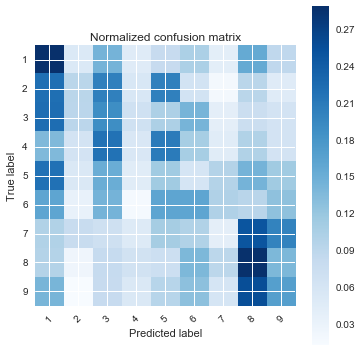

In [14]:
tree_result = example.DTree(min_samples_leaf = 20)

In [15]:
print('prediction:', tree_result[0].predict(new_X_norm))
try: print('prediction prob:', tree_result[0].predict_proba(new_X_norm))
except: pass

prediction: [2 7 3]
prediction prob: [[ 0.2         0.15        0.25        0.05        0.05        0.          0.1
   0.          0.2       ]
 [ 0.04347826  0.08695652  0.17391304  0.08695652  0.          0.13043478
   0.04347826  0.30434783  0.13043478]
 [ 0.11111111  0.02777778  0.02777778  0.30555556  0.16666667  0.11111111
   0.08333333  0.05555556  0.11111111]]


In [16]:
tree_result[0].predict(new_X_norm) == new_Y_norm

array([False, False,  True], dtype=bool)

________________________________________________________________________________
Training: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

train time: 0.202s
test time:  0.001s
accuracy:   0.191

Classification report:
             precision    recall  f1-score   support

          1       0.21      0.43      0.28       173
          2       0.03      0.01      0.01       108
          3       0.19      0.18      0.18       174
          4       0.12      0.02      0.03       110
          5       0.13      0.14      0.13       132
          6       0.16      0.08      0.10       118
          7       0.09      0.03      0.04       100
          8       0.21      0.35      0.26       122
          9       0.26      0.29      0.28       148

avg / total       0.16      0.

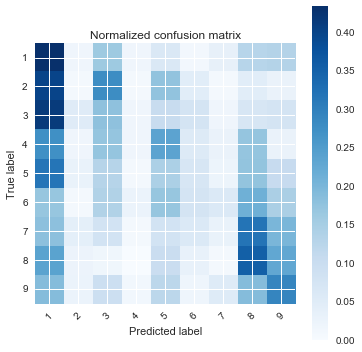

In [17]:
lgr = example.logisticRegression()

In [18]:
print('prediction:', lgr[0].predict(new_X_norm))
try: print('prediction prob:', lgr[0].predict_proba(new_X_norm))
except: pass

prediction: [0 7 0]
prediction prob: [[ 0.32841756  0.13833981  0.15827025  0.14274158  0.04045821  0.06784817
   0.0974912   0.00863762  0.0177956 ]
 [ 0.00081826  0.02230745  0.01206987  0.01799483  0.04606171  0.22414923
   0.23428813  0.29008193  0.1522286 ]
 [ 0.23734429  0.11426352  0.14065219  0.12170088  0.16162072  0.10203775
   0.04090364  0.01361169  0.06786532]]


In [19]:
lgr[0].predict(new_X_norm) == new_Y_norm

array([False, False, False], dtype=bool)

________________________________________________________________________________
Training: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

train time: 0.015s
test time:  0.095s
accuracy:   0.165

Classification report:
             precision    recall  f1-score   support

          1       0.17      0.33      0.23       173
          2       0.10      0.10      0.10       108
          3       0.18      0.18      0.18       174
          4       0.10      0.05      0.07       110
          5       0.11      0.11      0.11       132
          6       0.12      0.09      0.11       118
          7       0.10      0.08      0.09       100
          8       0.25      0.24      0.25       122
          9       0.34      0.18      0.23       148

avg / total       0.17      0.16      0.16      1185



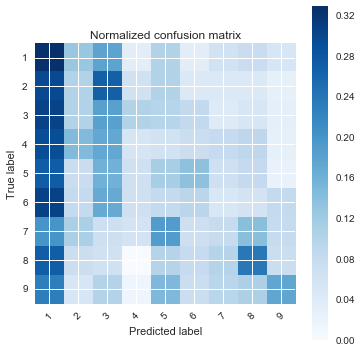

In [20]:
knn_result = example.KNN(n_neighbors = 5)

In [21]:
print('prediction:', knn_result[0].predict(new_X_norm))
try: print('prediction prob:', knn_result[0].predict_proba(new_X_norm))
except: pass

prediction: [6 6 6]
prediction prob: [[ 0.2  0.   0.   0.   0.2  0.   0.4  0.   0.2]
 [ 0.   0.   0.   0.   0.2  0.   0.8  0.   0. ]
 [ 0.   0.   0.2  0.2  0.2  0.   0.4  0.   0. ]]


In [22]:
knn_result[0].predict(new_X_norm) == new_Y_norm

array([False, False, False], dtype=bool)

________________________________________________________________________________
Training: 
GaussianNB()

train time: 0.012s
test time:  0.006s
accuracy:   0.187

Classification report:
             precision    recall  f1-score   support

          1       0.19      0.10      0.13       173
          2       0.12      0.10      0.11       108
          3       0.22      0.36      0.28       174
          4       0.06      0.03      0.04       110
          5       0.11      0.02      0.04       132
          6       0.10      0.13      0.11       118
          7       0.05      0.02      0.03       100
          8       0.20      0.42      0.27       122
          9       0.29      0.38      0.33       148

avg / total       0.16      0.19      0.16      1185



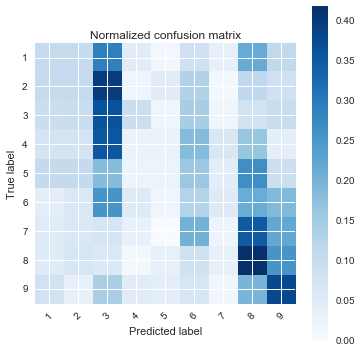

In [23]:
gnb_result = example.GaussianNaiveBayes()

In [24]:
print('prediction:', gnb_result[0].predict(new_X_norm))
try: print('prediction prob:', gnb_result[0].predict_proba(new_X_norm))
except: pass

prediction: [4 4 4]
prediction prob: [[  8.96100232e-05   2.41160157e-11   2.92579903e-10   5.31992974e-02
    9.46710852e-01   2.40198858e-07   1.37219643e-16   3.45725197e-48
    1.81702151e-11]
 [  2.58181026e-15   2.64106940e-30   1.99312593e-25   4.09102851e-24
    9.99993221e-01   1.88824309e-14   5.64252133e-06   2.03028433e-48
    1.13695298e-06]
 [  1.81910401e-08   2.76648572e-13   1.48467574e-09   6.43769727e-03
    9.93562283e-01   2.87949041e-11   7.42239862e-17   1.43237591e-51
    1.31358824e-12]]


In [25]:
bins

array([    0,     4,     6,     9,    11,    14,    17,    20,    21, 10000], dtype=int64)

In [26]:
gnb_result[0].predict(new_X_norm) == new_Y_norm

array([ True, False, False], dtype=bool)

________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

train time: 4.192s
test time:  0.001s
accuracy:   0.203

Classification report:
             precision    recall  f1-score   support

          1       0.21      0.43      0.28       173
          2       0.07      0.01      0.02       108
          3       0.22      0.22      0.22       174
          4       0.00      0.00      0.00       110
          5       0.13      0.13      0.13       132
          6       0.16      0.08      0.10       118
          7       0.08      0.01      0.02       100
          8       0.21      0.44      0.28       122
          9       0.26      0.30      0.28       148

avg / total       0.16      0.20      0.17      1185



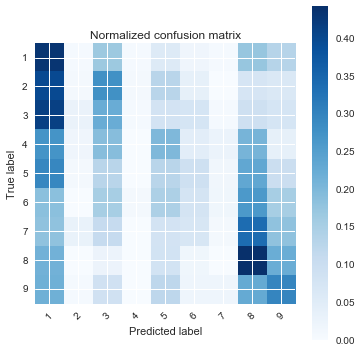

In [27]:
lsvc_result = example.linearSVC()

In [28]:
print('prediction:', lsvc_result[0].predict(new_X_norm))
try: print('prediction prob:', lsvc_result[0].predict_proba(new_X_norm))
except: pass

prediction: [0 7 0]


In [29]:
lsvc_result[0].predict(new_X_norm) == new_Y_norm

array([False, False, False], dtype=bool)

________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

train time: 0.166s
test time:  0.006s
accuracy:   0.187

Classification report:
             precision    recall  f1-score   support

          1       0.22      0.38      0.28       173
          2       0.13      0.12      0.12       108
          3       0.23      0.26      0.24       174
          4       0.13      0.09      0.11       110
          5       0.13      0.13      0.13       132
          6       0.15      0.12      0.13       118
          7       0.12      0.07      0.09       100
          8       0.20      0.20      0.20   

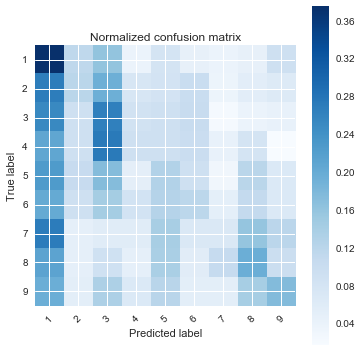

In [30]:
rfc_result = example.RandomForest()

In [31]:
print('prediction:', rfc_result[0].predict(new_X_norm))
try: print('prediction prob:', rfc_result[0].predict_proba(new_X_norm))
except: pass

prediction: [1 0 3]
prediction prob: [[ 0.   0.3  0.1  0.1  0.1  0.1  0.1  0.   0.2]
 [ 0.2  0.   0.   0.   0.2  0.1  0.1  0.2  0.2]
 [ 0.1  0.   0.1  0.2  0.   0.2  0.2  0.1  0.1]]


In [32]:
rfc_result[0].predict(new_X_norm) == new_Y_norm

array([False, False,  True], dtype=bool)